In [1]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 339 kB/s 


In [2]:
import os
import pandas as pd
import seaborn as sns
import scipy
from scipy import sparse
import numpy as np
import random
import implicit
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from IPython.display import Image
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


# [Implicit Library](https://github.com/benfred/implicit)

- ALS를 직접 구현해 봤지만 실제 프로덕션에 사용하기에 더 좋은 라이브러리가 존재
- 학습 속도를 최적화한 Implicit Library가 존재함.
- 이름을 보면 알 수 있듯이, Implicit Feedback을 처리하는 MF 모델이 구현되어 있음

라이브러리 설치
```
conda install -c conda-forge implicit implicit-proc=*=gpu
```
또는
```
conda install -c conda-forge implicit "implicit-proc=*=gpu"
```

## Implicit Feedback 데이터 활용

- UCI 데이터는 1강에서 살펴봤듯이 사용자의 상품 구매데이터로 이루어져 있음.
- 무비렌즈와 다르게 아이템에 대한 평점이 없이 구매 이력 데이터만 존재함.
- 해당 데이터를 Matrix Factorization에 적합하게 가공하고, 모델 학습을 통한 성능을 확인해본다.

In [3]:
# 데이터 로드
file_path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/online_retail.csv'
parse_date = lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M')
retail_df = pd.read_csv(file_path, encoding="utf-8", parse_dates = ['InvoiceDate'], date_parser = parse_date)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# 전처리 1. CustomerID가 없는 데이터 & Quantity가 음수인 데이터 제외
cleaned_retail_df = retail_df[(retail_df['Quantity'] > 0) & (retail_df['CustomerID'].notnull())]
cleaned_retail_df = cleaned_retail_df[['StockCode', 'Quantity', 'CustomerID', 'InvoiceDate']]
cleaned_retail_df['CustomerID'] = cleaned_retail_df['CustomerID'].astype(int)
print(cleaned_retail_df.shape)
cleaned_retail_df.head()

(397924, 4)


,StockCode,Quantity,CustomerID,InvoiceDate
0,85123A,6,17850,2010-12-01 08:26:00
1,71053,6,17850,2010-12-01 08:26:00
2,84406B,8,17850,2010-12-01 08:26:00
3,84029G,6,17850,2010-12-01 08:26:00
4,84029E,6,17850,2010-12-01 08:26:00


### 시간 기준 train / test 데이터 나누기

- 보통 실습자료에서 train 데이터와 test 데이터는 전체 데이터를 기반으로 랜덤하게 나눈다.
- 하지만 실제로는 과거 데이터를 가지고 미래 데이터를 예측하기 때문에, 특정한 시간을 기준으로 전후 데이터를 train / test 데이터로 나눈다.
- 특히 커머스 데이터와 같은 경우, 같은 상품을 다시 구매할 수 있기 때문에 이미 구매한 상품을 다시 추천하기도 한다.

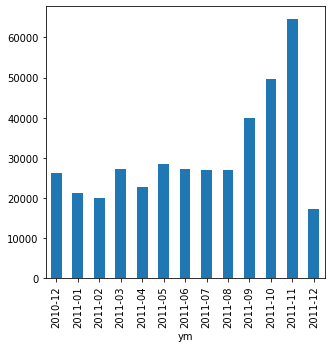

In [6]:
# 연도와 월 추출
cleaned_retail_df['ym'] = cleaned_retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])
cleaned_retail_df.groupby('ym')['StockCode'].count().plot.bar(figsize=(5,5))  # 연도-월별 구매량 시각화

In [7]:
# 2011-10까지 데이터 : train  /  2011-11 부터의 데이터 : test
train = cleaned_retail_df[cleaned_retail_df['ym'] <= '2011-10']
test = cleaned_retail_df[cleaned_retail_df['ym'] > '2011-10']

In [8]:
# train / test 데이터셋에서 CustomerID 별로 구매한 아이템을 Groupby해서 [Customer, StockCode] 별 Quantity를 계산
# 각 데이터셋에는 CustomerID, StockCode, Quantity 3개의 컬럼만 존재

train = train.groupby(['CustomerID', 'StockCode']).sum().reset_index()
test = test.groupby(['CustomerID', 'StockCode']).sum().reset_index()
train

,CustomerID,StockCode,Quantity
0,12346,23166,74215
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,30
...,...,...,...
221385,18287,84920,4
221386,18287,85039A,96
221387,18287,85039B,120
221388,18287,85040A,48


In [9]:
# Implicit 라이브러리에 넣기 위해 user_id와 item_id를 category 타입으로 변경
# category type으로 형변환 이후
# .cat.codes --> 숫자형 리턴

train['CustomerID'] = train['CustomerID'].astype('category')
train['StockCode'] = train['StockCode'].astype('category')
train['user_id'] = train['CustomerID'].cat.codes
train['item_id'] = train['StockCode'].cat.codes
train

,CustomerID,StockCode,Quantity,user_id,item_id
0,12346,23166,74215,0,1995
1,12347,16008,24,1,25
2,12347,17021,36,1,87
3,12347,20665,6,1,129
4,12347,20719,30,1,166
...,...,...,...,...,...
221385,18287,84920,4,3973,3042
221386,18287,85039A,96,3973,3144
221387,18287,85039B,120,3973,3145
221388,18287,85040A,48,3973,3147


In [10]:
# user_id --> 기존 CustomerID
# item_id --> 기존 StockCode
user_id_map = dict(enumerate(train['CustomerID'].cat.categories))
item_id_map = dict(enumerate(train['StockCode'].cat.categories))
train_user_list = list(user_id_map.values())
train_itme_list = list(item_id_map.values())

user_id_map

{0: 12346,
 1: 12347,
 2: 12348,
 3: 12350,
 4: 12352,
 5: 12353,
 6: 12354,
 7: 12355,
 8: 12356,
 9: 12358,
 10: 12359,
 11: 12360,
 12: 12361,
 13: 12362,
 14: 12363,
 15: 12364,
 16: 12365,
 17: 12370,
 18: 12371,
 19: 12372,
 20: 12373,
 21: 12375,
 22: 12377,
 23: 12378,
 24: 12379,
 25: 12380,
 26: 12381,
 27: 12383,
 28: 12384,
 29: 12386,
 30: 12388,
 31: 12390,
 32: 12393,
 33: 12394,
 34: 12395,
 35: 12397,
 36: 12398,
 37: 12399,
 38: 12401,
 39: 12402,
 40: 12403,
 41: 12405,
 42: 12406,
 43: 12407,
 44: 12408,
 45: 12409,
 46: 12410,
 47: 12412,
 48: 12413,
 49: 12414,
 50: 12415,
 51: 12417,
 52: 12418,
 53: 12420,
 54: 12421,
 55: 12422,
 56: 12423,
 57: 12424,
 58: 12425,
 59: 12426,
 60: 12427,
 61: 12428,
 62: 12429,
 63: 12430,
 64: 12431,
 65: 12432,
 66: 12433,
 67: 12434,
 68: 12435,
 69: 12436,
 70: 12437,
 71: 12438,
 72: 12441,
 73: 12444,
 74: 12446,
 75: 12447,
 76: 12448,
 77: 12449,
 78: 12450,
 79: 12451,
 80: 12453,
 81: 12454,
 82: 12455,
 83: 12456,
 8

In [11]:
# 이후 test 데이터로 성능평가시 user별로 성능을 평가할 때 사용
# user_id_map의 key, value가 바뀐 딕셔너리 생성
# item_id_map의 key, value가 바뀐 딕셔너리 생성
customer_id_map = dict()
stock_code_map = dict()

for x, y in zip(user_id_map.keys(), user_id_map.values()):
  customer_id_map[y] = x

for x, y in zip(item_id_map.keys(), item_id_map.values()):
  stock_code_map[y] = x

stock_code_map

{'10002': 0,
 '10080': 1,
 '10120': 2,
 '10123C': 3,
 '10124A': 4,
 '10124G': 5,
 '10125': 6,
 '10133': 7,
 '10135': 8,
 '11001': 9,
 '15030': 10,
 '15034': 11,
 '15036': 12,
 '15039': 13,
 '15044A': 14,
 '15044B': 15,
 '15044C': 16,
 '15044D': 17,
 '15056BL': 18,
 '15056N': 19,
 '15056P': 20,
 '15058A': 21,
 '15058B': 22,
 '15058C': 23,
 '15060B': 24,
 '16008': 25,
 '16010': 26,
 '16011': 27,
 '16012': 28,
 '16014': 29,
 '16015': 30,
 '16016': 31,
 '16020C': 32,
 '16033': 33,
 '16043': 34,
 '16045': 35,
 '16046': 36,
 '16048': 37,
 '16049': 38,
 '16052': 39,
 '16054': 40,
 '16151A': 41,
 '16156L': 42,
 '16156S': 43,
 '16161G': 44,
 '16161M': 45,
 '16161P': 46,
 '16161U': 47,
 '16162L': 48,
 '16162M': 49,
 '16168M': 50,
 '16169E': 51,
 '16169K': 52,
 '16169M': 53,
 '16169N': 54,
 '16169P': 55,
 '16202A': 56,
 '16202B': 57,
 '16202E': 58,
 '16206B': 59,
 '16207A': 60,
 '16207B': 61,
 '16216': 62,
 '16218': 63,
 '16219': 64,
 '16225': 65,
 '16235': 66,
 '16236': 67,
 '16237': 68,
 '16238

In [64]:
# train데이터의 user-item 행렬
# 평점 대신 user가 item을 구매한 횟수(Quantity)를 r_ui로 사용
# sparse.csr_matrix((data, (row,col))) 의 형태로 작성 
sparse_item_user = sparse.csr_matrix((train['Quantity'].astype(float),
                                      (train['item_id'], train['user_id'])))

In [50]:
# user-item 행렬의 가능한 모든 조합의 개수
matrix_size = sparse_user_item.shape[0] * sparse_user_item.shape[1]
# user-item entry가 실제로 존재하는 조함의 개수
num_purchases = len(sparse_user_item.nonzero()[0])
# sparsity 계산
sparsity = 100 * (1 - (num_purchases / matrix_size))
sparsity

98.45807881314344

## ALS 모델 학습 및 평가
- [ALS](https://implicit.readthedocs.io/en/latest/als.html)

In [73]:
# 모델 초기화
# alpha는 'Collaborative Filtering for Implicit Feedback Datasets' 논문에서 소개된 confidence 값
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=1000, use_gpu=True)
alpha=1
model.fit(alpha * sparse_item_user)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
user_vecs = model.user_factors.to_numpy() # User Matrix: P
item_vecs = model.item_factors.to_numpy() # Item Matrix: Q
print(user_vecs.shape)
print(item_vecs.shape)

(3613, 20)
(3974, 20)


In [75]:
sparse_user_item = sparse_item_user.T.tocsr()

In [78]:
# 유저 0에게 가장 적합한 아이템 10개를 추천해봅시다

[(item, score) for item, score in model.recommend(0, sparse_user_item, 10)]

ValueError: ignored

In [ ]:
# 유저 0에게 가장 적합한 아이템 10개를 추천해봅시다

[(item, score) for item, score in model.recommend(0, sparse_user_item.T, 10)]

[(1996, 1.1099195),
 (1995, 0.9997142),
 (1994, 0.90076715),
 (2000, 0.77582365),
 (2001, 0.76949716),
 (1999, 0.75147355),
 (1546, 0.69185275),
 (1547, 0.6638466),
 (1545, 0.6598426),
 (2111, 0.65519166)]

### Top N Recommendation
- Precision@K, Recall@K로 성능을 평가해보자

In [18]:
k = 20

# train 데이터셋에 user가 없는 경우엔 추천이 안되므로 best-seller 추천 리스트를 미리 만들어 놓는다
popular_item_k = list(train.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)
precisions = []
recalls = []

# test 데이터셋의 user별로 Top-K 추천을 통해 user별 precision / recall을 구한다
cold_start=0
user_grouped = test.groupby('CustomerID')

for customer_id, user_df in tqdm(user_grouped):

  # test 데이터셋에 존재하는 user가 이미 구매한 item -> 정답(buy_items)
  buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
               for stock_code in user_df['StockCode'].unique()]
  
  # test 데이터셋에 train 데이터셋에서 지정한 user가 있는 경우
  if customer_id in customer_id_map:

    user_id = customer_id_map[customer_id]
    user_vector = np.squeeze(model.user_factors[user_id].to_numpy().transpose())
    scores = item_vecs.dot(user_vector)
    top_k_item = np.argpartition(scores, -k)[-k:]
  
  else:
    cold_start += 1
    top_k_item = popular_item_k
  
  intersect = set(buy_items).intersection(set(top_k_item))
  precision = len(intersect) / len(top_k_item)
  recall = len(intersect) / len(buy_items)
  precisions.append(precision)
  recalls.append(recall)

print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))
print('cold_start_user:', cold_start)

 91%|█████████ | 1733/1909 [00:00<00:00, 2331.51it/s]


ValueError: ignored

In [ ]:
k = 20

# training data에 user가 없는 경우엔 추천이 안되므로 인기도 기반 추천 리스트를 미리 만들어 놓는다.
popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)

precisions = []
recalls = []

# 사용자 별로 Top N 추천을 하여 사용자 별 precision recall을 구한다.

cold_start = 0
user_grouped = test_df.groupby('CustomerID')
for customer_id, user_df in tqdm(user_grouped):
    
    # test 데이터에 존재하는 사용자가 이미 구매한 아이템 = 정답
    buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                 for stock_code in user_df['StockCode'].unique()]
    
    if customer_id in customer_id_map:
        
        user_id = customer_id_map[customer_id]
        user_vector = np.squeeze(model.user_factors[user_id].to_numpy().transpose())
        scores = item_vecs.dot(user_vector)
        top_k_item = np.argpartition(scores, -k)[-k:]

        # 모델에서 top k 아이템을 선정하는 함수를 이미 제공함
        # top_k_item = [item for item, _ in model.recommend(user_id, sparse_user_item.T, k, filter_already_liked_items=False)]

    else:
        cold_start += 1
        top_k_item = popular_item_at_k
        
    intersect = set(buy_items).intersection(set(top_k_item))
    
    precision = len(intersect)/len(top_k_item)
    recall = len(intersect)/len(buy_items)
    
    precisions.append(precision)
    recalls.append(recall)
    
print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))
print('cold_start_user:', cold_start)

100%|██████████| 1909/1909 [00:00<00:00, 8052.83it/s]

precision@k: 0.11710319539025668
recall@k: 0.11689293033300316
cold_start_user: 365


In [ ]:
# 간단한 grid search

grid_search_result = []

for factors in [10, 20, 40]:
    for alpha in [1, 5, 10]:
        
        # 모델 학습
        model = implicit.als.AlternatingLeastSquares(factors=factors, regularization = 0.1, iterations = 1000)
        model.fit(alpha * sparse_user_item.T)
        
        user_vecs = model.user_factors.to_numpy()
        item_vecs = model.item_factors.to_numpy()
        
        # 모델 평가
        k = 20        
        popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)
        precisions = []
        recalls = []

        user_grouped = test_df.groupby('CustomerID')
        for customer_id, user_df in user_grouped:

            buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                         for stock_code in user_df['StockCode'].unique()]

            if customer_id in customer_id_map:
                user_id = customer_id_map[customer_id]
                user_vector = np.squeeze(model.user_factors[user_id].to_numpy().transpose())
                scores = item_vecs.dot(user_vector)
                top_k_item = np.argpartition(scores, -k)[-k:]

            else:
                top_k_item = popular_item_at_k

            intersect = set(buy_items).intersection(set(top_k_item))

            precision = len(intersect)/len(top_k_item)
            recall = len(intersect)/len(buy_items)

            precisions.append(precision)
            recalls.append(recall)

        print("factors:", factors, "alpha", alpha)
        print('precision@k:', np.mean(np.asarray(precisions)))
        print('recall@k:', np.mean(np.asarray(recalls)))
        grid_search_result.append([factors, alpha, np.mean(np.asarray(precisions)), np.mean(np.asarray(recalls))])


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 10 alpha 1
precision@k: 0.09955474070193819
recall@k: 0.09446472682001353


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 10 alpha 5
precision@k: 0.07569408067050812
recall@k: 0.07619406661809687


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 10 alpha 10
precision@k: 0.06361969617600839
recall@k: 0.06427544412198642


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 20 alpha 1
precision@k: 0.11650078575170247
recall@k: 0.11637847325712929


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 20 alpha 5
precision@k: 0.08653745416448404
recall@k: 0.09255835148978381


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 20 alpha 10
precision@k: 0.06980094290204297
recall@k: 0.07958919080581135


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 40 alpha 1
precision@k: 0.13941854374017812
recall@k: 0.14209053471362448


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 40 alpha 5
precision@k: 0.10083813514929284
recall@k: 0.1186294547844451


  0%|          | 0/1000 [00:00<?, ?it/s]

factors: 40 alpha 10
precision@k: 0.08425877422734417
recall@k: 0.10515311873787232


In [ ]:
pd.DataFrame(grid_search_result,
             columns = ['factors', 'alpha', 'precision@k', 'recall@k']).sort_values(by='precision@k', ascending=False)

,factors,alpha,precision@k,recall@k
6,40,1,0.139419,0.142091
3,20,1,0.116501,0.116378
7,40,5,0.100838,0.118629
0,10,1,0.099555,0.094465
4,20,5,0.086537,0.092558
8,40,10,0.084259,0.105153
1,10,5,0.075694,0.076194
5,20,10,0.069801,0.079589
2,10,10,0.063620,0.064275


## BPR 모델 학습 및 평가
- [BPR](https://implicit.readthedocs.io/en/latest/bpr.html)

In [79]:
# 모델 학습
factors = 40
model = implicit.bpr.BayesianPersonalizedRanking(factors=factors, regularization = 0.01, iterations = 5000)

# BPR에는 alpha가 없음
model.fit(sparse_user_item.T)

user_vecs = model.user_factors.to_numpy()
item_vecs = model.item_factors.to_numpy()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [80]:
# 모델 평가

k = 20        
popular_item_at_k = list(train.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)
precisions = []
recalls = []

user_grouped = test.groupby('CustomerID')
for customer_id, user_df in user_grouped:

    buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                 for stock_code in user_df['StockCode'].unique()]

    if customer_id in customer_id_map:
        user_id = customer_id_map[customer_id]
        user_vector = np.squeeze(model.user_factors[user_id].to_numpy().transpose())
        scores = item_vecs.dot(user_vector)
        top_k_item = np.argpartition(scores, -k)[-k:]

    else:
        top_k_item = popular_item_at_k

    intersect = set(buy_items).intersection(set(top_k_item))

    precision = len(intersect)/len(top_k_item)
    recall = len(intersect)/len(buy_items)

    precisions.append(precision)
    recalls.append(recall)

print("factors:", factors)
print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))

ValueError: ignored

# [annoy](https://github.com/spotify/annoy)를 활용한 빠른 서빙
- 추천해야 할 아이템 숫자가 굉장히 많아질 경우 실시간 서빙에는 어려움이 따릅니다.
- 만약 배치로 서빙 결과를 모두 만들어 준비해놓는다면 문제는 없지만, 그렇지 않은 경우 서빙 속도는 정확도보다 더 중요할 수 있습니다.
- annoy를 활용하여 추천의 정확도를 조금 포기하는 대신 짧은 latency를 얻을 수 있습니다.

In [81]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=40, regularization = 0.1, iterations = 1000, use_gpu = True)
alpha = 1

model.fit(alpha * sparse_user_item.T)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [82]:
user_vecs = model.user_factors.to_numpy()
item_vecs = model.item_factors.to_numpy()
print(user_vecs.shape)
print(item_vecs.shape)

(3613, 40)
(3974, 40)


## 주어진 아이템과 비슷한 아이템을 추천하는 Task

In [83]:
# 기존 방식대로 모든 아이템에 대해서 유사도를 계산하고 정렬해서 top n개를 추출해봅시다

itemid = 0
N = 20

# cosine 유사도를 구하기 위해서는 모든 아이템 벡터의 norm을 구해야 합니다
item_norms = np.linalg.norm(item_vecs, axis=-1)
item_norms[item_norms == 0] = 1e-10

# 주어진 아이템 벡터와 norm
target_item_vec = item_vecs[itemid]
target_item_norm = item_norms[0]

In [84]:
# score는 cosine 유사도이며 유사도가 클수록 주어진 아이템과 비슷하다는 의미입니다
scores = item_vecs.dot(target_item_vec) / (target_item_norm * item_norms)

# score가 높은 아이템 N개 추출
best = np.argpartition(scores, -N)[-N:]
sorted(zip(best.tolist(), scores[best].tolist()), key=lambda x: -x[1])

[(0, 1.0000001192092896),
 (3869, 0.9065825939178467),
 (2904, 0.5424119830131531),
 (1181, 0.4487861394882202),
 (3439, 0.4115142524242401),
 (2810, 0.409826397895813),
 (2205, 0.3693961203098297),
 (1613, 0.36437198519706726),
 (2637, 0.33581650257110596),
 (795, 0.3258441090583801),
 (506, 0.30888447165489197),
 (1723, 0.30766791105270386),
 (3200, 0.3065479099750519),
 (3161, 0.30395811796188354),
 (1076, 0.29998379945755005),
 (976, 0.29892265796661377),
 (2471, 0.2986261248588562),
 (1510, 0.2973489463329315),
 (335, 0.2925647795200348),
 (2978, 0.2920299172401428)]

In [86]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 5.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395202 sha256=b135083348389315d613e66b72748ef4a278a1f084f0c83bc34e86f4efbd5e4f
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [87]:
# annoy를 사용해 tree를 만들어봅니다

import annoy

# annoy의 파라미터, tree의 개수가 많아질수록 appoximate의 정확도가 올라갑니다. 대신의 탐색 속도는 더 느려집니다
n_trees = 20

# angular는 cosine 유사도와 거의 유사합니다
# https://en.wikipedia.org/wiki/Cosine_similarity#Angular_distance_and_similarity
similar_items_index = annoy.AnnoyIndex(item_vecs.shape[1], "angular")

# 모든 아이템 벡터를 annoy에 넣습니다
for i, row in enumerate(item_vecs):
    similar_items_index.add_item(i, row)
    
# annoy 모델을 build 합니다
similar_items_index.build(n_trees)

True

In [88]:
# annoy 안에 있는 전체 아이템 개수
similar_items_index.get_n_items()

3974

In [89]:
# 0번 아이템과 유사한 아이템을 annoy를 활용해서 추천해봅시다

itemid = 0
N = 20

neighbours, dist = similar_items_index.get_nns_by_item(itemid, N, include_distances=True)

In [90]:
[(x, y) for x, y in zip(neighbours, dist)]

[(0, 0.0),
 (3869, 0.43224409222602844),
 (1181, 1.0499656200408936),
 (3200, 1.1776689291000366),
 (1076, 1.183229684829712),
 (3639, 1.1915277242660522),
 (3535, 1.2065683603286743),
 (368, 1.2102932929992676),
 (1279, 1.2119510173797607),
 (413, 1.2142043113708496),
 (1679, 1.2180572748184204),
 (3421, 1.2202590703964233),
 (2253, 1.2338411808013916),
 (3508, 1.2454427480697632),
 (2204, 1.2458746433258057),
 (3971, 1.2460007667541504),
 (1784, 1.2460870742797852),
 (3081, 1.247031331062317),
 (1710, 1.2510379552841187),
 (818, 1.2542648315429688)]

## 유저에게 아이템 추천

In [93]:
# 123번 유저에게 als 모델을 활용해서 추천을 수행합니다

user_id = 123
N = 20

# model.recommend method 사용
[(item, score) for item, score in model.recommend(user_id, sparse_user_item.T, N)]

ValueError: ignored

In [94]:
# annoy를 사용해 tree를 만들어봅니다

import annoy

# annoy의 파라미터
# tree의 개수가 많아질수록 appoximate의 정확도가 올라갑니다. 대신의 탐색 속도는 더 느려집니다
n_trees = 20

# 유저 - 아이템은 dot product를 사용합니다
# 유저 벡터와 아이템의 dot product가 MF 추천 모델의 스코어 이기 때문입니다.
user_items_index = annoy.AnnoyIndex(item_vecs.shape[1], "dot")

# 모든 아이템 벡터를 annoy에 넣습니다
for i, row in enumerate(item_vecs):
    user_items_index.add_item(i, row)
    
# annoy 모델을 build 합니다
user_items_index.build(n_trees)

True

In [95]:
# 123번 유저과 유사한 아이템을 annoy를 활용해서 추천해봅시다

user_id = 123
N = 20

neighbours, dist = user_items_index.get_nns_by_vector(user_vecs[user_id], N, include_distances=True)

In [96]:
[(x, y) for x, y in zip(neighbours, dist)]

[(300, 0.9716318845748901),
 (3348, 0.8641027212142944),
 (1583, 0.8345261812210083),
 (1193, 0.7503871917724609),
 (176, 0.7269783020019531),
 (137, 0.7077468633651733),
 (1842, 0.6038810014724731),
 (3003, 0.5957753658294678),
 (158, 0.5673990249633789),
 (758, 0.5568322539329529),
 (3094, 0.5334808230400085),
 (1589, 0.5242571830749512),
 (305, 0.5224220156669617),
 (2136, 0.5187907218933105),
 (1170, 0.47148799896240234),
 (3671, 0.4426790773868561),
 (3630, 0.4420585334300995),
 (2974, 0.4402102828025818),
 (299, 0.4344930946826935),
 (1216, 0.4335712790489197)]

## annoy 서빙의 속도 비교

In [97]:
N = 20

mf_serving = list()
annoy_serving= list()

for i in range(1000):
    
    # 랜덤하게 아이템 선택
    itemid = random.sample([i for i in range(item_vecs.shape[0])], 1)[0]
    
    # annoy를 활용하지 않은 서빙
    mf_now = datetime.now()
    item_norms = np.linalg.norm(item_vecs, axis=-1)
    item_norms[item_norms == 0] = 1e-10
    target_item_vec = item_vecs[itemid]
    target_item_norm = item_norms[itemid]
    scores = item_vecs.dot(target_item_vec) / (target_item_norm * item_norms)
    topN = np.argpartition(scores, -N)[-N:]
    mf_serving.append((datetime.now() - mf_now).microseconds)
    
    # annoy를 활용한 서빙
    annoy_now = datetime.now()
    topN, dist = similar_items_index.get_nns_by_item(itemid, N, include_distances=True)
    
    annoy_serving.append((datetime.now() - annoy_now).microseconds)

    
print("mf serving: ", np.mean(np.asarray(mf_serving)))
print("annoy serving: ", np.mean(np.asarray(annoy_serving)))

mf serving:  429.056
annoy serving:  78.754


## annoy implemented ALS
- 유저에게 아이템을 추천할 때도 annoy를 활용하여 빠르게 서빙할 수 있습니다
- implict library에서 직접 annoy가 구현된 als matrix factorization을 제공합니다

In [98]:
import implicit

# initialize a annoy als model
# https://implicit.readthedocs.io/en/latest/ann.html

# annoy가 적용된 ALS 모델
# 실제 학습은 동일하지만 추천 서빙 annoy를 활용하여 합니다
annoy_model = implicit.approximate_als.AnnoyAlternatingLeastSquares(
    approximate_similar_items=True, approximate_recommend=True, n_trees=100,
    factors=40, regularization = 0.1, iterations = 1000
)

alpha = 1
annoy_model.fit(alpha * sparse_user_item.T)

# 기존 ALS 모델
als_model = implicit.als.AlternatingLeastSquares(factors=40, regularization = 0.1, iterations = 1000, use_gpu=True)

alpha = 1
als_model.fit(alpha * sparse_user_item.T)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [102]:
# 모델 평가

k = 20        
popular_item_at_k = list(train.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)

# 유저별로 평가하기 위해 그룹핑
user_grouped = test.groupby('CustomerID')

# annoy als 모델과 als 모델에 대해 성능을 비교해봅시다
for model in [annoy_model, als_model]:
    
    precisions = []
    recalls = []

    # 유저별로 precision / recall 성능을 평가함
    for customer_id, user_df in user_grouped:
        
        # test 데이터에 있는 유저가 실제로 구매한 아이템
        buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                     for stock_code in user_df['StockCode'].unique()]
        
        # train 데이터에 유저가 존재하는 경우
        if customer_id in customer_id_map:
            user_id = customer_id_map[customer_id]
            top_k_item = [id for id, score in model.recommend(user_id, sparse_user_item, N=k, filter_already_liked_items=False)]

        # train 데이터에 유저가 없는 경우
        else:
            top_k_item = popular_item_at_k
        
        # 추천 아이템 가운데 유저가 실제로 구매한 아이템 집합
        intersect = set(buy_items).intersection(set(top_k_item))
        
        # 성능 측정
        precision = len(intersect)/len(top_k_item)
        recall = len(intersect)/len(buy_items)

        precisions.append(precision)
        recalls.append(recall)
    
    print(model.__class__.__name__)
    print('precision@k:', np.mean(np.asarray(precisions)))
    print('recall@k:', np.mean(np.asarray(recalls)))

ValueError: ignored